In [4]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split

## Preprocessing

In [ ]:
df = pd.read_csv("../data/raw/steam_reviews-ENGLISH.csv")

In [4]:
df.head()

,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,votes_funny,...,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
0,292030,The Witcher 3: Wild Hunt,85184605,english,"One of the best RPG's of all time, worthy of a...",1611379970,1611379970,True,0,0,...,True,False,False,76561199054755373,5,3,5587.0,3200.0,5524.0,1.611384e+09
1,292030,The Witcher 3: Wild Hunt,85184171,english,"good story, good graphics. lots to do.",1611379264,1611379264,True,0,0,...,True,False,False,76561198170193529,11,1,823.0,823.0,823.0,1.611379e+09
2,292030,The Witcher 3: Wild Hunt,85184064,english,"dis gud,",1611379091,1611379091,True,0,0,...,True,False,False,76561198119302812,27,2,4192.0,3398.0,4192.0,1.611352e+09
3,292030,The Witcher 3: Wild Hunt,85180436,english,favorite game of all time cant wait for the Ne...,1611373086,1611373086,True,0,0,...,True,False,False,76561198065591528,33,1,23329.0,177.0,23329.0,1.611219e+09
4,292030,The Witcher 3: Wild Hunt,85179753,english,Why wouldn't you get this,1611371978,1611371978,True,0,0,...,True,False,False,76561198996835044,131,2,8557.0,2004.0,8557.0,1.611371e+09


In [5]:
df.shape

(9635437, 22)

### Assign ratings

Since we are committed to develop recommendation system using collaborative-filtering engine, one major component is missing which is rating points. To remedy that, we came up with a scheme that "assumes" the rating of the user on a scale from 1 to 5 based on their playtime. To elaborate, if the user playtime is greater than the median playtime of a particular game, then their assumed rating is 5. If their playtime is between the median and median multiplied by 0.8; then their rating is 4. If their playtime is between median multiply by 0.5 and less than 0.8; then their rating is 3. If their playtime is between median multiply by 0.1 and less than 0.5; then their rating is 2; other than that, then it is 1

First, we have to create a new column that fetch every games median playtime

In [4]:
median_df = df.groupby('app_name')["author.playtime_forever"].median()

In [5]:
median_df

app_name
20XX                                      1182.0
A Hat in Time                             1590.0
A Short Hike                               231.0
A Way Out                                  378.0
ARK: Survival Evolved                    14068.0
                                          ...   
XCOM 2                                    6768.0
Yakuza 0                                  3504.0
Youtubers Life                            1060.0
theHunter: Call of the Wild™              2888.0
三国群英传8 Heroes of the Three Kingdoms 8      655.0
Name: author.playtime_forever, Length: 315, dtype: float64

In [6]:
median_df = pd.DataFrame(median_df).reset_index()
median_df.columns = ['app_name', 'median_playtime']

In [7]:
median_df

,app_name,median_playtime
0,20XX,1182.0
1,A Hat in Time,1590.0
2,A Short Hike,231.0
3,A Way Out,378.0
4,ARK: Survival Evolved,14068.0
...,...,...
310,XCOM 2,6768.0
311,Yakuza 0,3504.0
312,Youtubers Life,1060.0
313,theHunter: Call of the Wild™,2888.0


In [8]:
df = pd.merge(df, median_df,right_on='app_name', left_on='app_name')

In [9]:
df.head()

,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,votes_funny,...,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played,median_playtime
0,292030,The Witcher 3: Wild Hunt,85184605,english,"One of the best RPG's of all time, worthy of a...",1611379970,1611379970,True,0,0,...,False,False,76561199054755373,5,3,5587.0,3200.0,5524.0,1.611384e+09,7483.0
1,292030,The Witcher 3: Wild Hunt,85184171,english,"good story, good graphics. lots to do.",1611379264,1611379264,True,0,0,...,False,False,76561198170193529,11,1,823.0,823.0,823.0,1.611379e+09,7483.0
2,292030,The Witcher 3: Wild Hunt,85184064,english,"dis gud,",1611379091,1611379091,True,0,0,...,False,False,76561198119302812,27,2,4192.0,3398.0,4192.0,1.611352e+09,7483.0
3,292030,The Witcher 3: Wild Hunt,85180436,english,favorite game of all time cant wait for the Ne...,1611373086,1611373086,True,0,0,...,False,False,76561198065591528,33,1,23329.0,177.0,23329.0,1.611219e+09,7483.0
4,292030,The Witcher 3: Wild Hunt,85179753,english,Why wouldn't you get this,1611371978,1611371978,True,0,0,...,False,False,76561198996835044,131,2,8557.0,2004.0,8557.0,1.611371e+09,7483.0


In [12]:
# Code from github user NightWind (github.com/AlbertNightwind)

def get_ratings(df_col):
    df_col['Rating'] = 0
    for i in range(len(df_col)):
        if df_col['author.playtime_forever'][i]>= df_col['median_playtime'][i]:
            df_col['Rating'][i] = 5
    #else:
     #   df_col['Rating'][i] = 2
        elif df_col['median_playtime'][i]>df_col['author.playtime_forever'][i]>= df_col['median_playtime'][i]*0.8:
            df_col['Rating'][i] = 4
        elif df_col['median_playtime'][i]*0.8>df_col['author.playtime_forever'][i]>= df_col['median_playtime'][i]*0.5:
            df_col['Rating'][i] = 3
        elif df_col['median_playtime'][i]*0.5>df_col['author.playtime_forever'][i]>= df_col['median_playtime'][i]*0.1:
            df_col['Rating'][i] = 2
        elif df_col['median_playtime'][i]*0.1>df_col['author.playtime_forever'][i]:
            df_col['Rating'][i] = 1
    return df_col

In [13]:
get_ratings(df)

/home/abdulium/miniconda3/envs/t5/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/abdulium/miniconda3/envs/t5/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/abdulium/miniconda3/envs/t5/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/abdulium

,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,votes_funny,...,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played,median_playtime,Rating
0,292030,The Witcher 3: Wild Hunt,85184605,english,"One of the best RPG's of all time, worthy of a...",1611379970,1611379970,True,0,0,...,False,76561199054755373,5,3,5587.0,3200.0,5524.0,1.611384e+09,7483.0,3
1,292030,The Witcher 3: Wild Hunt,85184171,english,"good story, good graphics. lots to do.",1611379264,1611379264,True,0,0,...,False,76561198170193529,11,1,823.0,823.0,823.0,1.611379e+09,7483.0,2
2,292030,The Witcher 3: Wild Hunt,85184064,english,"dis gud,",1611379091,1611379091,True,0,0,...,False,76561198119302812,27,2,4192.0,3398.0,4192.0,1.611352e+09,7483.0,3
3,292030,The Witcher 3: Wild Hunt,85180436,english,favorite game of all time cant wait for the Ne...,1611373086,1611373086,True,0,0,...,False,76561198065591528,33,1,23329.0,177.0,23329.0,1.611219e+09,7483.0,5
4,292030,The Witcher 3: Wild Hunt,85179753,english,Why wouldn't you get this,1611371978,1611371978,True,0,0,...,False,76561198996835044,131,2,8557.0,2004.0,8557.0,1.611371e+09,7483.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9635432,546560,Half-Life: Alyx,65645167,english,best game ever\n,1584986750,1584986750,True,0,0,...,False,76561198817267089,86,8,1055.0,14.0,45.0,1.611138e+09,995.0,5
9635433,546560,Half-Life: Alyx,65645125,english,Holy balls,1584986704,1584986704,True,0,0,...,False,76561197967033932,431,7,432.0,0.0,29.0,1.586628e+09,995.0,2
9635434,546560,Half-Life: Alyx,65645115,english,"A tripod thing bears down on you, it looks imm...",1584986693,1584986693,True,0,0,...,False,76561198046495482,70,10,3296.0,15.0,24.0,1.611080e+09,995.0,5
9635435,546560,Half-Life: Alyx,65645100,english,Honestly this is the best vr game ever,1584986673,1584986673,True,0,0,...,False,76561198176379749,79,17,2654.0,0.0,34.0,1.591634e+09,995.0,5


In [14]:
# pickle rating df if we need it in future
pickle.dump(df, open("df_rating.pickle", 'wb'))

In [ ]:
# # sparse matrix

# user_game_mat_ratings = pd.DataFrame(int(0),index=df['author.steamid'].unique() ,columns=df['app_name'].unique())

# reviewers, games, ratings = df['author.steamid'], df['app_name'], df['Rating']
# for rev, game, rating in zip(reviewers,games, ratings):
#     try:
#         user_game_mat_ratings.loc[int(rev),game] = rating
#     except:
#         continue
# user_game_mat_ratings

In [4]:
# drop unnessesary columns
cols = ['app_name',
       'author.steamid',
       'author.playtime_forever',
       'median_playtime',
       'Rating']
df.drop(columns=df.columns.difference(cols), inplace=True)

In [5]:
df.head()

,app_name,author.steamid,author.playtime_forever,median_playtime,Rating
0,The Witcher 3: Wild Hunt,76561199054755373,5587.0,7483.0,3
1,The Witcher 3: Wild Hunt,76561198170193529,823.0,7483.0,2
2,The Witcher 3: Wild Hunt,76561198119302812,4192.0,7483.0,3
3,The Witcher 3: Wild Hunt,76561198065591528,23329.0,7483.0,5
4,The Witcher 3: Wild Hunt,76561198996835044,8557.0,7483.0,5


In [6]:
# pickle rating_no_cols
pickle.dump(df, open("rating_no_cols.pickle", 'wb'))

In [2]:
#load df
df = pickle.load(open('rating_no_cols.pickle', 'rb'))

In [3]:
# create sparse matrix users as rows, games as columns
sparse = pd.pivot_table(df, index='author.steamid', columns='app_name', values='Rating').fillna(0).convert_dtypes()

In [4]:
sparse

,20XX,A Hat in Time,A Short Hike,A Way Out,ARK: Survival Evolved,ATLAS,Age of Empires II (2013),Age of Empires: Definitive Edition,American Truck Simulator,Among Us,...,We Were Here Too,Wolfenstein: Youngblood,X Rebirth,X-Blades,X-Plane 11,XCOM 2,Yakuza 0,Youtubers Life,theHunter: Call of the Wild™,三国群英传8 Heroes of the Three Kingdoms 8
author.steamid,,,,,,,,,,,,,,,,,,,,,
76561197960265730,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76561197960265745,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76561197960265747,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76561197960265778,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76561197960265781,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76561199132972128,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76561199132989128,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76561199133026644,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# pickle sparse
pickle.dump(sparse, open("ratings_sparse.pickle", 'wb'))

In [2]:
# load sparse
df = pickle.load(open("ratings_sparse.pickle", 'rb'))

In [6]:
# data is huge so we will deal with only a sample of 0.05

In [4]:
df.shape

(5287718, 315)

In [7]:
df.shape[0]*0.05

264385.9

In [4]:
sample, _ = train_test_split(df, train_size=0.05, random_state=7)

In [6]:
sample.shape

(264385, 315)

In [5]:
sample.head()

,20XX,A Hat in Time,A Short Hike,A Way Out,ARK: Survival Evolved,ATLAS,Age of Empires II (2013),Age of Empires: Definitive Edition,American Truck Simulator,Among Us,...,We Were Here Too,Wolfenstein: Youngblood,X Rebirth,X-Blades,X-Plane 11,XCOM 2,Yakuza 0,Youtubers Life,theHunter: Call of the Wild™,三国群英传8 Heroes of the Three Kingdoms 8
author.steamid,,,,,,,,,,,,,,,,,,,,,
76561198289110652,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76561198055060005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76561197970810628,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76561198440536071,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76561198069721420,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# pickle dump sample
pickle.dump(sample, open("sample_sparse.pickle", "wb"))

In [2]:
# pickle load sample
df = pickle.load(open("sample_sparse.pickle", "rb"))

In [5]:
df.shape

(264385, 315)

## Exploratory Data Analysis 

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/home/abdulium/miniconda3/envs/t5/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


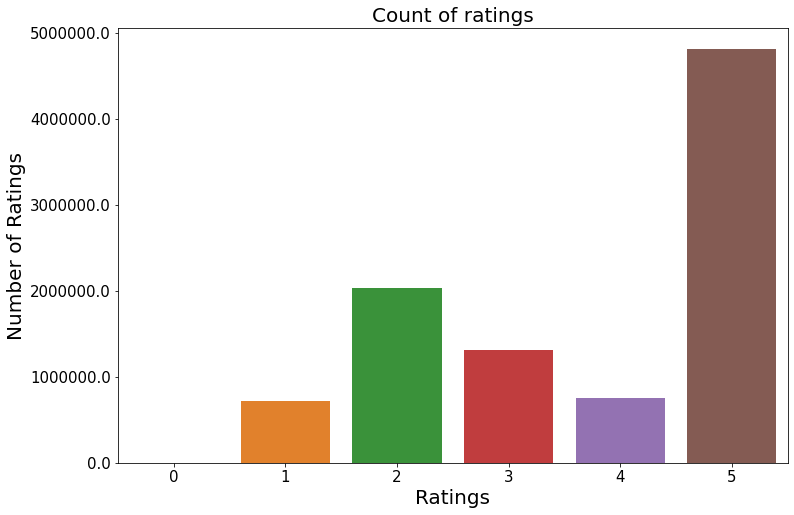

In [92]:
# plot ratings count
ratings_df = pickle.load(open("rating_no_cols.pickle", 'rb'))

plt.figure(figsize = (12, 8))
ax = sns.countplot(x="Rating", data=ratings_df)
ax.set_yticklabels([num for num in ax.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Count of ratings", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

In [93]:
ratings_df.columns

Index(['app_name', 'author.steamid', 'author.playtime_forever',
       'median_playtime', 'Rating'],
      dtype='object')

In [96]:
# count of rated games per player
num_rated_games_per_player = ratings_df.groupby("author.steamid")["Rating"].count().sort_values(ascending=False)
num_rated_games_per_player.head()

author.steamid
76561198062813911    149
76561198315585536    132
76561198045381877    103
76561198064946151    100
76561197969749884     88
Name: Rating, dtype: int64

In [98]:
# count of ratings per game
num_ratings_per_game = ratings_df.groupby("app_name")["Rating"].count().sort_values(ascending=False)
num_ratings_per_game.head()

app_name
Tom Clancy's Rainbow Six Siege    371154
Terraria                          370240
Garry's Mod                       331621
Grand Theft Auto V                319751
PLAYERUNKNOWN'S BATTLEGROUNDS     317846
Name: Rating, dtype: int64

## Collaborative-Filtering Recommendation Engine

In [5]:
from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

In [65]:
# ss = StandardScaler()
# ss_df = ss.fit_transform(df)

In [74]:
pca = PCA(n_components=100)

In [75]:
pca.fit_transform(df)

array([[-2.02540201e-02, -4.74802333e-01, -1.61319391e-01, ...,
         4.43564479e-02,  3.36284941e-02, -1.11418930e-02],
       [-6.95831910e-02, -4.57614548e-01, -1.29141796e-01, ...,
         1.12596622e-02, -1.28181819e-02,  1.53448017e-04],
       [ 9.43660246e-03, -4.45735903e-01, -1.29434992e-01, ...,
        -1.88731236e-02, -1.79900086e-02, -2.18961104e-03],
       ...,
       [ 7.06939792e-01,  6.26540684e-01,  2.61312819e+00, ...,
         2.53894961e-02,  5.01992665e-03,  5.41099705e-03],
       [ 7.06936263e-01,  6.40368053e-01,  2.62900628e+00, ...,
        -1.90975619e-01, -1.91835725e-02, -5.70568911e-01],
       [-5.63880171e-02, -4.67833312e-01, -1.20659564e-01, ...,
        -1.22894033e-02, -8.80172462e-03, -2.54728529e-03]])

In [76]:
# print(pca.explained_variance_)
# print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[0.0382081  0.07453839 0.10760027 0.14001696 0.17105569 0.20131222
 0.22823862 0.2525635  0.27203335 0.29014935 0.30808663 0.32573146
 0.3416279  0.35642555 0.37018225 0.38381597 0.39595497 0.40775518
 0.41871617 0.42942669 0.43978898 0.44994094 0.45974127 0.46950328
 0.47912727 0.48818789 0.49716077 0.50598936 0.51446809 0.52245091
 0.53019659 0.53752602 0.54476684 0.55189749 0.55899874 0.56593216
 0.57276334 0.57955771 0.58602576 0.59237927 0.59861545 0.60471532
 0.61078135 0.61676195 0.62238616 0.62799522 0.63352809 0.63873673
 0.64384167 0.6487147  0.65351828 0.65830716 0.66294867 0.66755736
 0.67208022 0.67653036 0.68095478 0.68531572 0.68959079 0.69375537
 0.69781612 0.70183579 0.70583194 0.70976051 0.71364576 0.71750653
 0.7213433  0.72513638 0.72889113 0.73261733 0.73631782 0.73997613
 0.74360149 0.74719549 0.75078483 0.75436353 0.7578836  0.76139191
 0.76486479 0.76828959 0.77167195 0.77499887 0.77827302 0.78153371
 0.78477004 0.7878934  0.79086772 0.79373475 0.79654595 0.7993

In [59]:
## Scaled with n_components = 100
# print(pca.explained_variance_)
# print(pca.explained_variance_ratio_)
# print(pca.explained_variance_ratio_.cumsum())

In [60]:
pd.DataFrame(np.diag(pca.explained_variance_ratio_.cumsum()))

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.038208,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.074538,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.1076,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.0000,0.140017,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.0000,0.000000,0.171056,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.0000,0.000000,0.000000,0.201312,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.228239,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.252564,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.272033,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.290149,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [61]:
pd.DataFrame(pca.components_) # latent features

,0,1,2,3,4,5,6,7,8,9,...,305,306,307,308,309,310,311,312,313,314
0,0.000321,0.008821,0.000324,-0.000691,-0.003064,-0.002503,0.000332,-0.000175,-0.004528,0.098624,...,0.000079,-0.000651,-0.000084,0.000127,-0.000742,-0.000653,-0.000323,3.010283e-04,-0.002777,-0.000021
1,-0.000471,0.003542,-0.000932,0.000726,-0.000919,-0.002937,-0.004589,-0.000666,-0.003715,-0.007553,...,0.000154,0.000283,-0.000675,0.000010,-0.000416,-0.002408,0.001981,3.319161e-04,-0.000429,0.000032
2,-0.000135,0.003593,-0.000300,0.000235,0.006327,0.000334,0.000407,0.000016,0.005805,-0.101886,...,0.000181,0.000609,0.000122,0.000303,0.000877,0.001664,0.002526,1.226024e-03,0.000536,-0.000030
3,0.000231,-0.001084,0.000188,-0.000158,0.029767,0.003562,0.003502,0.000095,-0.000129,-0.539695,...,0.000468,0.000739,0.000388,0.000178,0.000145,0.003808,0.001065,-6.947092e-04,0.001321,-0.000011
4,0.000141,-0.000631,0.000454,0.000152,0.004319,-0.000486,-0.000807,0.000297,0.002615,0.424864,...,0.000205,0.000252,0.000249,0.000118,0.000637,0.000963,-0.000181,1.838119e-04,0.000584,-0.000004
5,-0.000634,0.000930,-0.000355,0.000095,-0.026887,-0.001089,-0.005500,-0.000345,-0.006752,0.699341,...,0.000454,-0.000334,-0.001020,-0.000049,-0.000695,-0.007440,-0.001840,4.171632e-05,-0.000692,-0.000017
6,-0.000277,-0.003949,-0.000505,0.000289,0.044820,0.003588,-0.001713,-0.000162,-0.003110,0.034880,...,-0.000164,-0.000633,-0.000301,-0.000089,0.000033,-0.005794,-0.003908,-7.005636e-04,-0.000780,-0.000014
7,-0.000349,0.000086,-0.000324,0.000898,-0.020549,-0.002383,-0.004183,-0.000269,-0.002275,-0.007153,...,0.000220,-0.000606,-0.000575,0.000094,-0.000535,-0.006138,-0.002074,1.190277e-04,-0.000584,-0.000008
8,0.000403,0.011106,0.000818,0.001855,0.054477,0.000234,0.007223,0.000412,-0.004703,0.097162,...,0.000932,0.003079,0.001632,0.000723,-0.001483,0.025552,0.016129,1.703060e-03,-0.000115,-0.000010
9,0.000170,0.003964,0.001887,0.000007,0.353214,0.008026,0.003312,-0.000150,-0.005229,0.041053,...,0.000414,0.000777,0.001596,0.000352,-0.000590,0.006513,0.004013,-3.243992e-04,0.001877,-0.000001


In [82]:
pd.DataFrame(pca.components_, columns=pca.feature_names_in_).T[90].sort_values(ascending=False)[:20]

A Hat in Time                     0.564887
Enter the Gungeon                 0.225640
Satisfactory                      0.209180
Oxygen Not Included               0.159248
Papers, Please                    0.155039
BattleBlock Theater               0.124778
Human: Fall Flat                  0.122581
Frostpunk                         0.103552
Tabletop Simulator                0.076478
Ori and the Will of the Wisps     0.071414
The Binding of Isaac              0.069513
Assassin's Creed Odyssey          0.068971
Banished                          0.068289
Resident Evil 2                   0.066799
Tomb Raider                       0.055671
Totally Accurate Battlegrounds    0.054240
Planet Coaster                    0.049695
Dead Cells                        0.047343
OneShot                           0.040040
NieR:Automata™                    0.039250
Name: 90, dtype: float64

In [64]:
pd.DataFrame(pca.components_, columns=pca.feature_names_in_).T[27].sort_values(ascending=True)[:20]

DARK SOULS™ III               -0.257239
Fallout 4                     -0.115977
Euro Truck Simulator 2        -0.089817
Cities: Skylines              -0.086830
Don't Starve Together         -0.075645
The Elder Scrolls V: Skyrim   -0.071813
Tomb Raider                   -0.070686
The Forest                    -0.054447
No Man's Sky                  -0.041931
Sid Meier's Civilization V    -0.028424
BioShock Infinite             -0.026655
Sekiro™: Shadows Die Twice    -0.023079
The Witcher 3: Wild Hunt      -0.017953
Subnautica                    -0.014003
Rise of the Tomb Raider       -0.013156
American Truck Simulator      -0.012457
Don't Starve                  -0.011575
DARK SOULS™: REMASTERED       -0.010323
Darkest Dungeon®              -0.009070
FTL: Faster Than Light        -0.008203
Name: 27, dtype: float64

In [11]:
game_genre_mat = pd.DataFrame(pca.components_, columns=pca.feature_names_in_).T

In [102]:
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(game_genre_mat.T, dense_output=False)
similarity

array([[ 1.00000000e+00,  1.35834823e-15,  3.59251330e-16, ...,
         1.98129548e-17,  1.76880986e-16,  2.21156697e-17],
       [ 1.35834823e-15,  1.00000000e+00, -5.66208726e-16, ...,
        -2.35547843e-18, -7.12234576e-17,  1.85650938e-18],
       [ 3.59251330e-16, -5.66208726e-16,  1.00000000e+00, ...,
        -5.09999879e-17,  3.27842594e-17,  4.67135496e-18],
       ...,
       [ 1.98129548e-17, -2.35547843e-18, -5.09999879e-17, ...,
         1.00000000e+00, -2.12114909e-16, -1.48912352e-16],
       [ 1.76880986e-16, -7.12234576e-17,  3.27842594e-17, ...,
        -2.12114909e-16,  1.00000000e+00,  5.85312535e-16],
       [ 2.21156697e-17,  1.85650938e-18,  4.67135496e-18, ...,
        -1.48912352e-16,  5.85312535e-16,  1.00000000e+00]])

In [105]:
game_genre_mat

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
20XX,0.000321,-0.000471,-0.000135,0.000231,0.000141,-0.000634,-0.000277,-0.000349,0.000403,0.000170,...,-0.000081,0.000980,0.000491,0.000202,-0.000556,-0.001108,0.000034,0.001107,-3.777056e-04,0.000499
A Hat in Time,0.008822,0.003541,0.003593,-0.001085,-0.000631,0.000931,-0.003952,0.000090,0.011085,0.003988,...,-0.016261,0.013051,0.015268,0.042039,-0.000704,-0.024642,0.003451,0.028365,-6.676324e-02,0.020766
A Short Hike,0.000324,-0.000932,-0.000300,0.000188,0.000454,-0.000355,-0.000505,-0.000324,0.000818,0.001888,...,0.000135,0.001476,-0.001098,0.001063,0.000162,-0.001496,0.001527,0.002605,-1.079545e-03,0.001956
A Way Out,-0.000691,0.000726,0.000235,-0.000158,0.000152,0.000095,0.000289,0.000898,0.001855,0.000008,...,0.004748,0.002851,0.000712,-0.002096,-0.000729,-0.000099,0.001503,-0.001074,-5.772286e-04,-0.001919
ARK: Survival Evolved,-0.003064,-0.000919,0.006327,0.029767,0.004319,-0.026887,0.044820,-0.020549,0.054476,0.353213,...,-0.002570,0.003178,0.002860,0.001962,-0.002182,-0.003685,-0.009939,0.011465,-3.268034e-03,-0.000307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XCOM 2,-0.000656,-0.002406,0.001661,0.003811,0.000960,-0.007440,-0.005779,-0.006132,0.025594,0.006526,...,0.074689,0.155840,-0.119720,-0.007920,0.202579,0.051081,0.113757,-0.023855,-9.267127e-02,-0.153740
Yakuza 0,-0.000323,0.001980,0.002526,0.001066,-0.000182,-0.001838,-0.003908,-0.002074,0.016122,0.004015,...,-0.013008,0.040083,-0.009550,0.021683,-0.001676,-0.036288,0.039952,0.022149,1.990763e-02,0.003879
Youtubers Life,0.000301,0.000332,0.001226,-0.000695,0.000184,0.000042,-0.000701,0.000119,0.001703,-0.000324,...,0.001575,0.003257,0.000106,-0.000675,0.000613,0.000875,0.001611,0.001282,1.634256e-03,0.002700
theHunter: Call of the Wild™,-0.002778,-0.000430,0.000535,0.001321,0.000585,-0.000692,-0.000781,-0.000584,-0.000131,0.001860,...,-0.004740,0.000156,-0.054896,0.008893,0.015961,0.047561,0.031116,-0.009820,7.358953e-03,0.028117


In [107]:
df.head()

,20XX,A Hat in Time,A Short Hike,A Way Out,ARK: Survival Evolved,ATLAS,Age of Empires II (2013),Age of Empires: Definitive Edition,American Truck Simulator,Among Us,...,We Were Here Too,Wolfenstein: Youngblood,X Rebirth,X-Blades,X-Plane 11,XCOM 2,Yakuza 0,Youtubers Life,theHunter: Call of the Wild™,三国群英传8 Heroes of the Three Kingdoms 8
author.steamid,,,,,,,,,,,,,,,,,,,,,
76561198289110652,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76561198055060005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76561197970810628,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76561198440536071,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76561198069721420,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## problems:
* Cold start

In [110]:
import pandas as pd
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy

In [115]:
df.head()

,20XX,A Hat in Time,A Short Hike,A Way Out,ARK: Survival Evolved,ATLAS,Age of Empires II (2013),Age of Empires: Definitive Edition,American Truck Simulator,Among Us,...,We Were Here Too,Wolfenstein: Youngblood,X Rebirth,X-Blades,X-Plane 11,XCOM 2,Yakuza 0,Youtubers Life,theHunter: Call of the Wild™,三国群英传8 Heroes of the Three Kingdoms 8
author.steamid,,,,,,,,,,,,,,,,,,,,,
76561198289110652,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76561198055060005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76561197970810628,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76561198440536071,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76561198069721420,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [118]:
ratings_df.head()

,app_name,author.steamid,author.playtime_forever,median_playtime,Rating
0,The Witcher 3: Wild Hunt,76561199054755373,5587.0,7483.0,3
1,The Witcher 3: Wild Hunt,76561198170193529,823.0,7483.0,2
2,The Witcher 3: Wild Hunt,76561198119302812,4192.0,7483.0,3
3,The Witcher 3: Wild Hunt,76561198065591528,23329.0,7483.0,5
4,The Witcher 3: Wild Hunt,76561198996835044,8557.0,7483.0,5


In [119]:
from surprise import Dataset
from surprise import Reader
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_df[['author.steamid', "app_name", 'Rating']], reader)

In [ ]:
from surprise import SVD
from surprise.model_selection import cross_validate

svd = SVD(verbose=True, n_epochs=10)
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)


Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9


In [ ]:
trainset = data.build_full_trainset()
svd.fit(trainset)